TAREA 1: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc.

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

TAREA 1: Captura una o varias imágenes con monedas no solapadas.

# Módulos necesarios

In [226]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función Para Mostrar Imágenes

In [227]:
def mostrar_imagenes(images, titles=None):
    """
    Muestra una o más imágenes usando Matplotlib.

    Args:
        images (list or np.ndarray): Una imagen o lista de imágenes en formato RGB.
        titles (list or str, optional): Un título o lista de títulos para cada imagen. Si no se especifica,
                                        se asignan títulos predeterminados como 'Imagen 1', 'Imagen 2', etc.

    Returns:
        None: La función muestra las imágenes y no devuelve nada.
    
    Raises:
        ValueError: Si el número de títulos no coincide con el número de imágenes.
    
    Example:
        image1 = cv2.imread('imagen1.jpg')
        image2 = cv2.imread('imagen2.jpg')
        mostrar_imagenes([image1, image2], ["Título 1", "Título 2"])
    """
    
    # Si solo se pasa una imagen, convertirla en lista para simplificar el código
    if not isinstance(images, list):
        images = [images]
    
    # Si no se pasan títulos, asignar títulos por defecto
    if titles is None:
        titles = [f"Imagen {i+1}" for i in range(len(images))]
    elif not isinstance(titles, list):
        titles = [titles]
    
    # Verificar que el número de títulos coincida con el número de imágenes
    if len(titles) != len(images):
        raise ValueError("El número de títulos no coincide con el número de imágenes.")
    
    # Mostrar las imágenes en un gráfico con múltiples subplots
    num_images = len(images)
    plt.figure(figsize=(15, 5 * num_images))  # Ajustar el tamaño de la figura
    for i, img in enumerate(images):
        plt.subplot(1, num_images, i + 1)  # Configurar los subplots
        plt.imshow(img) # Mostrar la imagen
        plt.title(titles[i]) # Agregar el título
        plt.axis("off")  # Ocultar los ejes
    
    plt.show()

# Procesamiento de Imagen para Conteo de Monedas

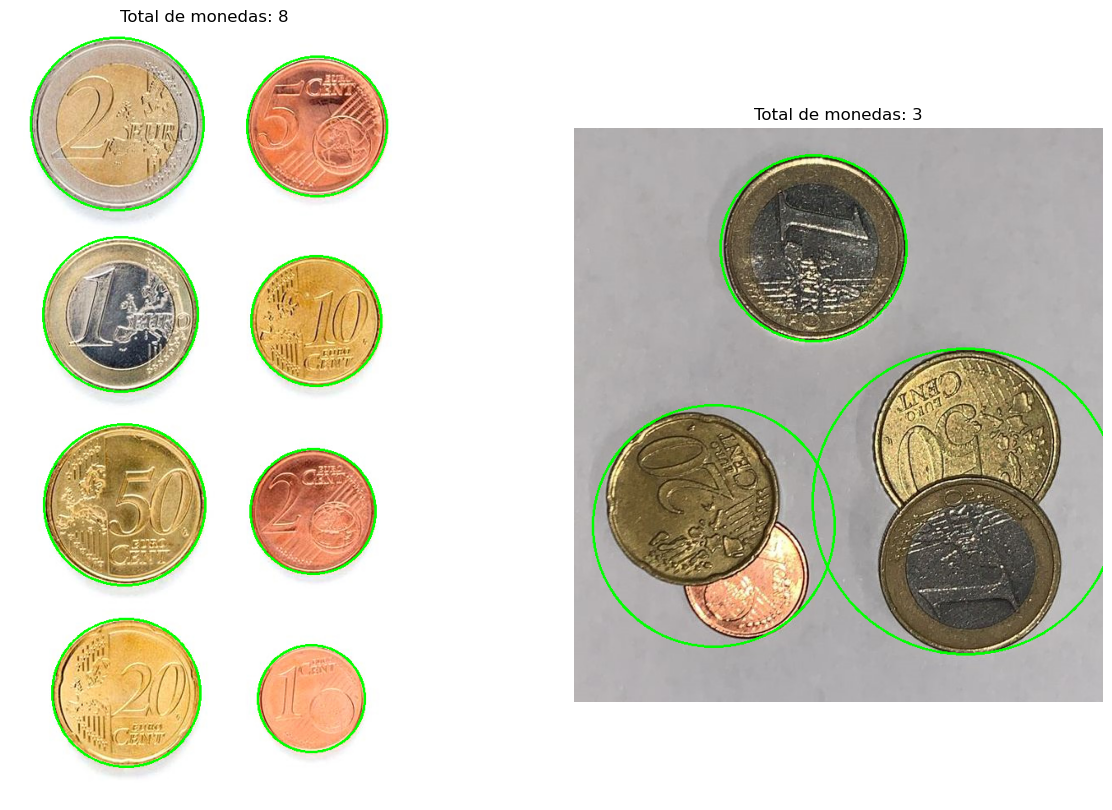

In [228]:
def detectar_monedas(image):
    """
    Detecta monedas en una imagen y dibuja los contornos de las monedas detectadas.

    Args:
        image (String): Dirección a la imagen a procesar.

    Returns:
        np.ndarray: Una imagen en formato RGB con los contornos de las monedas dibujados.
    """
    
    # Leer la imagen en RGB
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    
    # Convertir la imagen a escala de grises
    img_gris = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Aplicar thresholding para obtener una imagen binaria
    th, img_th = cv2.threshold(
        img_gris,
        0,
        255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    
    # Obtener los contornos exteriores de la imagen binaria
    global contornos
    contornos, jerarquia = cv2.findContours(
        img_th,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Dibujar los contornos de las monedas en la imagen original
    # Si hay contornos, dibujarlos en la imagen original
    if contornos is not None:
        monedas = 0

        # Iterar sobre los contornos
        for contorno in contornos:
            # Filtrar contornos pequeños
            if cv2.contourArea(contorno) > 10:
                monedas += 1
                # Obtener el centro y radio del círculo que encierra el contorno
                (x, y), radius = cv2.minEnclosingCircle(contorno)
                center = (int(x), int(y))
                radius = int(radius)
                cv2.circle(img, center, radius, (0, 255, 0), 2)

    return img, monedas

# Probar la función con una imagen
img1, titulo1 = detectar_monedas("./assets/Monedas.jpg")
img2, titulo2 = detectar_monedas("./assets/Monedas2.jpeg")

# Listas de imágenes y títulos
imgs = [img1, img2]
titulos = [titulo1, titulo2]

# Mostrar la imagen original y la imagen con los contornos de las monedas
mostrar_imagenes(
    imgs,
    [f'Total de monedas: {titulo}' for titulo in titulos]
)
    

Extra: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas.

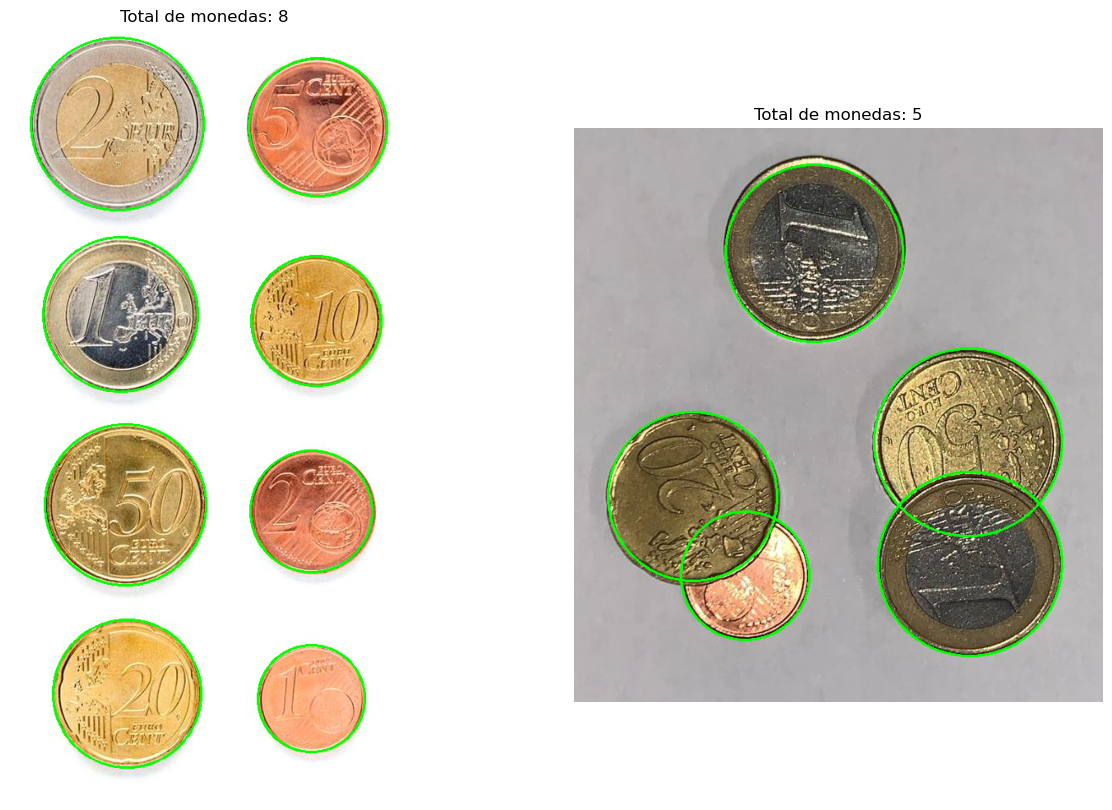

In [229]:
def detectar_monedas_mejorado(ruta, dp=1, min_dist=100, param1=200, param2=35, min_radius=37, max_radius=200):
    """
    Detecta monedas en una imagen aunque estén solapadas y dibuja los contornos de las monedas detectadas.

    Args:
        ruta (str): Dirección a la imagen a procesar.
        dp (float): Inverso de la relación de resolución de la imagen acumuladora.
        min_dist (int): Distancia mínima entre los centros de los círculos detectados.
        param1 (int): Umbral para el detector de bordes de Canny.
        param2 (int): Umbral para el acumulador de Hough.
        min_radius (int): Radio mínimo de los círculos a detectar.
        max_radius (int): Radio máximo de los círculos a detectar.

    Returns:
        tuple: Imagen con los contornos de las monedas dibujados, número de monedas detectadas.
    """
    global circulos
    try:
        # Leer la imagen en RGB
        imagen = cv2.cvtColor(cv2.imread(ruta), cv2.COLOR_BGR2RGB)
        if imagen is None:
            raise FileNotFoundError(f"No se pudo cargar la imagen de la ruta: {ruta}")
        
        # Convertir la imagen a escala de grises
        img_gris = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)

        # Suavizar la imagen para reducir el ruido
        img_suavizada = cv2.GaussianBlur(img_gris, (9, 9), 0)

        # Localizar los círculos en la imagen suavizada usando la transformada de Hough
        circulos = cv2.HoughCircles(
            img_suavizada,
            cv2.HOUGH_GRADIENT,
            dp=dp,
            minDist=min_dist,
            param1=param1,
            param2=param2,
            minRadius=min_radius,
            maxRadius=max_radius
        )

        if circulos is None:
            raise ValueError("No se encontraron círculos en la imagen")

        # Redondear los valores de los círculos detectados
        circulos = np.uint16(np.around(circulos))

        total_monedas = 0

        # Dibujar los círculos detectados en la imagen original
        for circulo in circulos[0, :]:
            total_monedas += 1
            center = (circulo[0], circulo[1])  # Coordenadas del centro del círculo
            radius = circulo[2]  # Radio del círculo
            cv2.circle(imagen, center, radius, (0, 255, 0), 2)  # Dibujar el círculo en verde

        return imagen, total_monedas

    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return None, 0

# Probar la función con una imagen
img1, titulo1 = detectar_monedas_mejorado("./assets/Monedas.jpg")
img2, titulo2 = detectar_monedas_mejorado("./assets/Monedas2.jpeg")

# Listas de imágenes y títulos
imgs = [img1, img2]
titulos = [titulo1, titulo2]

# Mostrar la imagen original y la imagen con los contornos de las monedas
mostrar_imagenes(
    imgs,
    [f'Total de monedas: {titulo}' for titulo in titulos]
)

Tarea: Identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€).

# Clase Moneda para Métodos Comunes

In [230]:
class Moneda:
    """
    Clase para representar una moneda con su nombre, valor, 
    diámetro y rango de tamaño en píxeles.
    """
    def __init__(self, nombre, valor, diametro):
        self.nombre = nombre
        self.valor = valor
        self.diametro = diametro
        self.cantidad = 0
        self.pixel_min = None
        self.pixel_max = None
    
    def __str__(self) -> str:
        return f"Moneda: {self.nombre} - Valor: {self.valor} - Rango de tamaño: {self.pixel_min} - {self.pixel_max} píxeles"
    
    def resetear_cantidad(self):
        """
        Resetea la cantidad de monedas de este tipo.
        """
        self.cantidad = 0
    
    def incrementar_cantidad(self):
        """
        Incrementa la cantidad de monedas de este tipo.
        """
        self.cantidad += 1
    
    def total_valor(self):
        """
        Calcula el valor total de las monedas de este tipo.
        
        Returns:
            float: El valor total de las monedas de este tipo.
        """
        return self.cantidad * self.valor
    
    def mostrar_monedas(monedas):
        """
        Muestra una tabla con las monedas y sus atributos.

        Args:
            monedas (list): Lista de objetos de la clase Moneda.
        
        Returns:
            None: La función no devuelve nada, pero imprime una tabla con los atributos de las monedas.
        """
        print("{:<10} {:<10} {:<10} {:<10} {:<10} {:>10} {:>10}".format("Nombre", "Cantidad", "Valor", "Total", "Diametro", "PixMin", "PixMax"))
        for moneda in monedas:
            print("{:<10} {:<10} {:<10} {:<10} {:<10} {:10.2f} {:10.2f}".format(moneda.nombre, moneda.cantidad, moneda.valor, moneda.total_valor(), moneda.diametro, moneda.pixel_min, moneda.pixel_max))
    
    @staticmethod
    def calcular_rangos(monedas, nombre_ref, pixel_ref):
        """
        Calcula los rangos de tamaño de las monedas en píxeles.
        
        Args:
            monedas (list): Lista de objetos de la clase Moneda.
            nombre_ref (Moneda): Moneda de referencia para el cálculo de los rangos.
            pixel_ref (int): Diámetro en píxeles de la moneda de referencia.
        
        Returns:
            None: La función no devuelve nada, pero actualiza los atributos pixel_min y pixel_max de cada objeto Moneda.
        """
        # Margen de error para el cálculo de los rangos
        error = 3
        
        # Obtener diámetro de la moneda de referencia
        diametro_ref = nombre_ref.diametro
        
        # Factor de escala
        factor_escala = pixel_ref / diametro_ref
        
        # Calcular los rangos de tamaño de las monedas
        for moneda in monedas:
            moneda.pixel_min = moneda.diametro * factor_escala - error
            moneda.pixel_max = moneda.diametro * factor_escala + error

# Pruebas de la clase Moneda

# Crear objetos de la clase Moneda
monedas = [
    Moneda("1 cent", 0.01, 16.25),
    Moneda("2 cent", 0.02, 18.75),
    Moneda("5 cent", 0.05, 21.25),
    Moneda("10 cent", 0.1, 19.75),
    Moneda("20 cent", 0.20, 22.25),
    Moneda("50 cent", 0.5, 24.25),
    Moneda("1 eur", 1, 23.25),
    Moneda("2 eur", 2, 25.75)
]

# Calcular los rangos de tamaño de las monedas a partir de la moneda de 5 cent
Moneda.calcular_rangos(monedas, monedas[2], 75)

# Mostrar las monedas y sus atributos
Moneda.mostrar_monedas(monedas)
        

Nombre     Cantidad   Valor      Total      Diametro       PixMin     PixMax
1 cent     0          0.01       0.0        16.25           54.35      60.35
2 cent     0          0.02       0.0        18.75           63.18      69.18
5 cent     0          0.05       0.0        21.25           72.00      78.00
10 cent    0          0.1        0.0        19.75           66.71      72.71
20 cent    0          0.2        0.0        22.25           75.53      81.53
50 cent    0          0.5        0.0        24.25           82.59      88.59
1 eur      0          1          0          23.25           79.06      85.06
2 eur      0          2          0          25.75           87.88      93.88


Tarea 1.1: identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€).

# Clasificación de Dinero

In [231]:
def clasificar_monedas(monedas):
    """
    Clasifica los contornos de las monedas en las diferentes categorías de monedas.

    Args:
        monedas (list): Lista de objetos de la clase Moneda.

    Returns:
        list: Lista de contornos clasificados por tipo de moneda.
    """
    
    # Recorrer los contornos
    for contorno in contornos:
        # Obtener el radio y el centro del círculo que encierra el contorno
        (x, y), radius = cv2.minEnclosingCircle(contorno)
        centro = (x, y)
        diametro = radius * 2
        
        # Recorrer las monedas
        for moneda in monedas:
            # Verificar si el área del contorno está dentro del rango de tamaño de la moneda
            if moneda.pixel_min <= diametro <= moneda.pixel_max:
                # Incrementar la cantidad de monedas de ese tipo
                moneda.incrementar_cantidad()
                print(f"Moneda de {moneda.nombre} detectada.")
                yield moneda.nombre, (centro[0], centro[1], radius)

def clasificar_monedas_mejorado(monedas):
    """
    Clasifica los círculos de las monedas en las diferentes categorías de monedas.

    Args:
        monedas (list): Lista de objetos de la clase Moneda.

    Returns:
        list: Lista de círculos clasificados por tipo de moneda.
    """
    
    # Recorrer los círculos
    for circulo in circulos[0, :]:
        # Obtener el radio y el centro del círculo
        x, y, radius = circulo
        diametro = radius * 2
        
        # Recorrer las monedas
        for moneda in monedas:
            # Verificar si el área del círculo está dentro del rango de tamaño de la moneda
            if moneda.pixel_min <= diametro <= moneda.pixel_max:
                # Incrementar la cantidad de monedas de ese tipo
                moneda.incrementar_cantidad()
                print(f"Moneda de {moneda.nombre} detectada.")
                yield moneda.nombre, (x, y, radius)

# Procesar Imagen con Click

Moneda de 1 cent detectada.
Moneda de 20 cent detectada.
Moneda de 2 cent detectada.
Moneda de 50 cent detectada.
Moneda de 10 cent detectada.
Moneda de 1 eur detectada.
Moneda de 5 cent detectada.
Moneda de 2 eur detectada.
Nombre     Cantidad   Valor      Total      Diametro       PixMin     PixMax
1 cent     1          0.01       0.01       16.25          128.65     134.65
2 cent     1          0.02       0.02       18.75          148.90     154.90
5 cent     1          0.05       0.05       21.25          169.15     175.15
10 cent    1          0.1        0.1        19.75          157.00     163.00
20 cent    1          0.2        0.2        22.25          177.25     183.25
50 cent    1          0.5        0.5        24.25          193.46     199.46
1 eur      1          1          1          23.25          185.36     191.36
2 eur      1          2          2          25.75          205.61     211.61


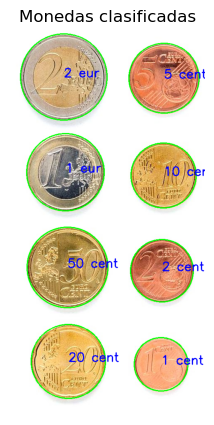

Valor total de las monedas:  3.88 eur


In [232]:
def click(event, x, y, flags, param):
    """
    Función para manejar los eventos de click del mouse.

    Args:
        event (int): Tipo de evento.
        x (int): Coordenada x del evento.
        y (int): Coordenada y del evento.
        flags (int): Flags del evento.
        param (object): Parámetro adicional del evento.
    """
    global point
    if event == cv2.EVENT_LBUTTONDOWN:
        point = (x, y)
        cv2.destroyAllWindows()

def interaccion(ruta, tipo_conteo=None):
    """
    Función que interactúa con el usuario para procesar una imagen y clasificar las monedas.

    Args:
        ruta (String): Dirección a la imagen a procesar.
    
    Returns:
        None: La función no devuelve nada, pero muestra las monedas detectadas, sus valores 
              y el total.
    """
    # Resetear la cantidad de monedas
    for moneda in monedas:
        moneda.resetear_cantidad()
    
    # Cargar la imagen y detectar las monedas
    img = cv2.imread(ruta)
    if tipo_conteo == "mejorado":
        img, _ = detectar_monedas_mejorado(ruta)
    else:
        img, _ = detectar_monedas(ruta)
    
    # Mostrar la imagen con los contornos de las monedas y esperar a que el usuario haga click
    cv2.imshow("Imagen", img)
    cv2.setWindowTitle('Imagen', "Haga click sobre la moneda de 1 EURO")
    cv2.setMouseCallback("Imagen", click)
    cv2.waitKey(0)
    
    # Comprobar si se hizo click en una moneda
    assert point is not None, "No se ha seleccionado una moneda."
    
    if tipo_conteo == "mejorado":
        for borde in circulos[0, :]:
            cx, cy, radio = borde
            if abs(cx - point[0]) ** 2 + abs(cy - point[1]) ** 2 <= radio ** 2:
                Moneda.calcular_rangos(monedas, monedas[6], radio*2)
                break
        else:
            raise Exception("El usuario no hizo clic dentro de ninguna moneda.")
    else:
        # Determinar la moneda que ha sido seleccionada
        for contorno in contornos:
            # Obtener el radio y el centro del círculo que encierra el contorno
            (x, y), radius = cv2.minEnclosingCircle(contorno)
            center = (x, y)
            
            # Verificar si el punto seleccionado está dentro de una moneda
            if abs(center[0] - point[0])**2 + abs(center[1] - point[1])**2 <= radius**2:
                # Calcular el diámetro de la moneda seleccionada
                diametro = radius * 2
                
                # Calcular los rangos de tamaño de las monedas a partir de la moneda seleccionada
                Moneda.calcular_rangos(monedas, monedas[6], diametro)
                break
        else:
            raise Exception("No se ha seleccionado una moneda.")
    
    if tipo_conteo == "mejorado":
        # Usar función con detección mejorada
        clasificaciones = clasificar_monedas_mejorado(monedas)
    else:
        # Clasificar las monedas
        clasificaciones = clasificar_monedas(monedas)
    
    # Añadir el nombre de la moneda a sus coordenadas
    for moneda, (x, y, radio) in clasificaciones:
        cv2.putText(img, moneda, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
    
    # Mostrar las monedas y sus atributos
    Moneda.mostrar_monedas(monedas)
    
    # Mostrar la imagen con los nombres de las monedas
    mostrar_imagenes(img, "Monedas clasificadas")
    
    # Calcular el valor total de las monedas
    print("Valor total de las monedas: ", sum([moneda.total_valor() for moneda in monedas]), "eur")

# Probar la función interaccion con una imagen
interaccion("./assets/Monedas.jpg")
#interaccion("./assets/Monedas.jpg", "mejorado")
#interaccion("./assets/Monedas2.jpeg") # No recomendado por fallo en la detección de monedas
#interaccion("./assets/Monedas2.jpeg", "mejorado")
